# 3. Feature Selection for Domestic and Public Buildings

<hr style="border:2px solid black">

# Outline <a id='index'></a>
1. [Introduction](#1)
1. [Sorting Feature Importance for Domestic Building](#2)
    * [2.1 Define functions](#2.1)
    * [2.2 GBOOST](#2.2)
    * [2.3 XGBOOST](#2.3)
    * [2.4 RF](#2.4)
    * [2.5 DT](#2.5)
1. [Sorting Feature Importance for Public Building](#3)
    * [3.1 GBOOST](#3.1)
    * [3.2 XGBOOST](#3.2)
    * [3.3 RF](#3.3)
    * [3.4 DT](#3.4)
1. [Conclusion](#4)
1. [References](#5)

<hr style="border:2px solid black">

# 1. Introduction [^](#index) <a name="1"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;This notebook has developed four selected models to train our previous data, which are GB, XGBOOST, RF, and DT. These models are selected due to their ability to rank feature importance
by splitting each node using the Gini impurity index [1,2]. The same models are used for domestic and public buildings, and 
the top 15 
features are selected as input for model development in the next Jupyter Notebook.
The reason is that the feature importance score is deficient starting from the 16th feature and above
for both types of buildings.
First, data is pre-processed separately
for domestic and public buildings. To properly rank the feature importance, the data will 
not be normalized 
since we want to determine the interpretability between other features 
with the target variable.Thus, the models are evaluated using R-squared since it is often preferred for model comparison as it is unitless 
and indicates the goodness of fit. We will select models with the highest R-squared value (near 1) will be 
selected for feature importance.It took longer than the other models, and the optimum hyperparameters are
still pre-determined.<div>

In [1]:
import time
import numpy as np 
import pandas as pd
from scipy import stats
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Sorting Feature Importance for Domestic Building [^](#index) <a name="2"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;Firstly, data points for Domestic buildings is read using panda 
dataframe.
Then, any negative values from the target variable (Energy Consumption will be removed).
Next, other features that are not related wiht spatial and socioeconomic features are 
dropped.
The latest dataframe will have 25000 rows with 40 columns including the target variable.
The data is split using train test split with 80:20 ratio and random state 21.Based on 
the R-squared values
GB has the highest value and ist feature importance is used as input model later.<div>

In [2]:
dom='/home/ffs223/Downloads/GHGs_coding/DOM_Main code/Job Portfolio/DOM_1723_25k_uprn complete.csv'
dom_df=pd.read_csv(dom)

dom_df

,ENERGY_CONSUMPTION_CURRENT,LMK_KEY,ADDRESS1,BUILDING_REFERENCE_NUMBER,POSTCODE,TENURE,UPRN,UPRN_SOURCE,PROPERTY_TYPE,BUILT_FORM,...,ESTIMATED_FLOOR_COUNT,ESTIMATE_TOTAL_FLOOR_AREA_ALL,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,COUNT_D_UPRNS,MIX_CLASS,DEC_COUNT,EPC_RATING_COUNT_DOM,AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT,AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT
0,380,574002,617240,170062,88777,1,1.000223e+11,1,1,5,...,25,1383.00,371.78,11.64,67,5,0,161,60.0,3
1,139,173171,165100,870255,109748,1,1.002280e+10,0,2,4,...,13,109.82,54.91,7.20,110,6,0,0,80.0,2
2,228,765513,640430,397739,119317,1,3.409152e+07,0,1,4,...,22,188.00,67.29,10.00,171,6,0,0,58.0,3
3,472,752269,471970,22717,26735,1,2.071315e+08,1,1,1,...,22,2087.00,749.30,8.66,180,5,0,70,72.0,2
4,417,809970,247116,10227,79475,4,1.000202e+11,1,3,3,...,13,85.00,43.89,7.49,110,6,0,69,40.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,236,322899,432338,622751,13552,3,6.030807e+06,0,1,4,...,13,113.00,58.66,6.34,110,6,0,0,67.0,3
24996,247,524645,625191,803023,95237,2,1.000219e+11,0,1,4,...,25,745.00,191.85,12.88,249,6,0,90,66.0,3
24997,248,787562,582306,459454,43730,2,1.000231e+11,0,1,3,...,28,2693.00,641.99,13.87,208,5,0,61,69.0,2
24998,125,229053,73073,721667,92621,1,1.210040e+08,0,2,4,...,13,78.00,55.97,5.96,0,0,0,0,63.0,3


In [3]:
dom_df['INSPECTION_DATE'] = pd.to_datetime(dom_df['INSPECTION_DATE'])

In [4]:
negative_values = dom_df[dom_df['ENERGY_CONSUMPTION_CURRENT'] < 0]
negative_values

,ENERGY_CONSUMPTION_CURRENT,LMK_KEY,ADDRESS1,BUILDING_REFERENCE_NUMBER,POSTCODE,TENURE,UPRN,UPRN_SOURCE,PROPERTY_TYPE,BUILT_FORM,...,ESTIMATED_FLOOR_COUNT,ESTIMATE_TOTAL_FLOOR_AREA_ALL,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,COUNT_D_UPRNS,MIX_CLASS,DEC_COUNT,EPC_RATING_COUNT_DOM,AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT,AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT
3179,-252,292573,621570,503862,46950,1,1.000831e+10,0,1,5,...,25,4793.0,1674.27,9.81,198,5,0,2,79.0,2


In [5]:
dom_df.columns

Index(['ENERGY_CONSUMPTION_CURRENT', 'LMK_KEY', 'ADDRESS1',
       'BUILDING_REFERENCE_NUMBER', 'POSTCODE', 'TENURE', 'UPRN',
       'UPRN_SOURCE', 'PROPERTY_TYPE', 'BUILT_FORM', 'year', 'INSPECTION_DATE',
       'CO2_EMISSIONS_CURRENT', 'CURRENT_ENERGY_RATING',
       'CURRENT_ENERGY_EFFICIENCY', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
       'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL',
       'MULTI_GLAZE_PROPORTION', 'TRANSACTION_TYPE', 'GLAZED_AREA',
       'EXTENSION_COUNT', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION', 'WINDOWS_ENERGY_EFF',
       'WINDOWS_ENV_EFF', 'WALLS_DESCRIPTION', 'WALLS_ENERGY_EFF',
       'WALLS_ENV_EFF', 'ROOF_DESCRIPTION', 'MAIN_FUEL',
       'CONSTRUCTION_AGE_BAND', 'ENVIRONMENT_IMPACT_CURRENT',
       'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION',
       'LIGHTING_ENV_EFF', 'LIGHTING_ENERGY_EFF', 'LIGHTING_DESCRIPTION',
       'MAINHEATC_ENV_EFF', 'MAINHEAT_ENERGY_EFF', 'MA

In [6]:

drop1=['LMK_KEY','BUILDING_REFERENCE_NUMBER','year',
       'COUNT_D_UPRNS','DEC_COUNT', 'AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT',
       'AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT','EPC_RATING_COUNT_DOM','UPRN_SOURCE',
      'WARD','POSTCODE','OS_TOPO_TOID','CURRENT_ENERGY_RATING', 'CURRENT_ENERGY_RATING',
       'ENVIRONMENT_IMPACT_CURRENT','CO2_EMISS_CURR_PER_FLOOR_AREA','WINDOWS_ENERGY_EFF',
       'WINDOWS_ENV_EFF','WALLS_ENERGY_EFF','WALLS_ENV_EFF','ENVIRONMENT_IMPACT_CURRENT',
      'CURRENT_ENERGY_EFFICIENCY','LIGHTING_ENV_EFF', 'LIGHTING_ENERGY_EFF','MAINHEAT_ENERGY_EFF',
       'MAINHEAT_ENV_EFF','HOT_WATER_ENERGY_EFF', 'HOT_WATER_ENV_EFF','SCU_ID','EPC_RATING_COUNT_DOM',
       'AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT','CO2_EMISSIONS_CURRENT','FLOOR_LEVEL',
       'AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT','MAINHEATC_ENV_EFF','ESTIMATE_TOTAL_FLOOR_AREA_ALL'
      ]

dom_df.drop(columns=drop1,axis=1,inplace=True)

In [7]:
dom_df.set_index(['UPRN','INSPECTION_DATE'], inplace=True)

In [8]:
dom_df

,,ENERGY_CONSUMPTION_CURRENT,ADDRESS1,TENURE,PROPERTY_TYPE,BUILT_FORM,TOTAL_FLOOR_AREA,ENERGY_TARIFF,MAINS_GAS_FLAG,MULTI_GLAZE_PROPORTION,TRANSACTION_TYPE,...,OA,LSOA,MSOA,OAC,WARD_CODE,ADMINISTRATIVE_AREA,ESTIMATED_FLOOR_COUNT,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,MIX_CLASS
UPRN,INSPECTION_DATE,,,,,,,,,,,,,,,,,,,,,
1.000223e+11,2022-03-04,380,617240,1,1,5,51.0,8,1,100.0,4,...,18786,3770,756,23,463,27,25,371.78,11.64,5
1.002280e+10,2017-09-04,139,165100,1,2,4,131.0,6,1,100.0,4,...,24750,2484,496,31,263,17,13,54.91,7.20,6
3.409152e+07,2017-03-27,228,640430,1,1,4,72.0,6,1,60.0,4,...,9145,1850,365,13,420,13,22,67.29,10.00,6
2.071315e+08,2020-11-11,472,471970,1,1,1,42.0,7,0,75.0,4,...,7286,1484,280,15,357,10,22,749.30,8.66,5
1.000202e+11,2021-01-30,417,247116,4,3,3,34.0,5,0,100.0,9,...,2231,463,63,27,122,2,13,43.89,7.49,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6.030807e+06,2019-05-14,236,432338,3,1,4,50.0,6,1,100.0,11,...,23631,4177,850,24,36,30,13,58.66,6.34,6
1.000219e+11,2019-04-02,247,625191,2,1,4,75.0,8,1,0.0,10,...,14901,2980,606,8,684,22,25,191.85,12.88,6
1.000231e+11,2017-02-28,248,582306,2,1,3,44.0,6,1,100.0,10,...,8608,1736,355,17,55,12,28,641.99,13.87,5


In [9]:
dom_df.isnull().sum()

ENERGY_CONSUMPTION_CURRENT    0
ADDRESS1                      0
TENURE                        0
PROPERTY_TYPE                 0
BUILT_FORM                    0
TOTAL_FLOOR_AREA              0
ENERGY_TARIFF                 0
MAINS_GAS_FLAG                0
MULTI_GLAZE_PROPORTION        0
TRANSACTION_TYPE              0
GLAZED_AREA                   0
EXTENSION_COUNT               0
NUMBER_HABITABLE_ROOMS        0
NUMBER_HEATED_ROOMS           0
FLOOR_DESCRIPTION             0
WINDOWS_DESCRIPTION           0
WALLS_DESCRIPTION             0
ROOF_DESCRIPTION              0
MAIN_FUEL                     0
CONSTRUCTION_AGE_BAND         0
SOLAR_WATER_HEATING_FLAG      0
MECHANICAL_VENTILATION        0
LIGHTING_DESCRIPTION          0
MAINHEAT_DESCRIPTION          0
HOTWATER_DESCRIPTION          0
HEATING_COST_CURRENT          0
LIGHTING_COST_CURRENT         0
EASTING                       0
NORTHING                      0
LATITUDE                      0
LONGITUDE                     0
OA      

In [10]:
dom_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25000 entries, (100022296113.0, Timestamp('2022-03-04 00:00:00')) to (5300035710.0, Timestamp('2021-01-29 00:00:00'))
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ENERGY_CONSUMPTION_CURRENT  25000 non-null  int64  
 1   ADDRESS1                    25000 non-null  int64  
 2   TENURE                      25000 non-null  int64  
 3   PROPERTY_TYPE               25000 non-null  int64  
 4   BUILT_FORM                  25000 non-null  int64  
 5   TOTAL_FLOOR_AREA            25000 non-null  float64
 6   ENERGY_TARIFF               25000 non-null  int64  
 7   MAINS_GAS_FLAG              25000 non-null  int64  
 8   MULTI_GLAZE_PROPORTION      25000 non-null  float64
 9   TRANSACTION_TYPE            25000 non-null  int64  
 10  GLAZED_AREA                 25000 non-null  int64  
 11  EXTENSION_COUNT             25000 non-null  int64  
 

In [11]:
dom_df = dom_df[dom_df['ENERGY_CONSUMPTION_CURRENT'] >= 0]

In [12]:
rubbish = dom_df[dom_df['ENERGY_CONSUMPTION_CURRENT'] < 0]
rubbish

,,ENERGY_CONSUMPTION_CURRENT,ADDRESS1,TENURE,PROPERTY_TYPE,BUILT_FORM,TOTAL_FLOOR_AREA,ENERGY_TARIFF,MAINS_GAS_FLAG,MULTI_GLAZE_PROPORTION,TRANSACTION_TYPE,...,OA,LSOA,MSOA,OAC,WARD_CODE,ADMINISTRATIVE_AREA,ESTIMATED_FLOOR_COUNT,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,MIX_CLASS
UPRN,INSPECTION_DATE,,,,,,,,,,,,,,,,,,,,,


In [13]:
X = dom_df.drop(columns=['ENERGY_CONSUMPTION_CURRENT'])
Y =dom_df['ENERGY_CONSUMPTION_CURRENT']


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=21)

In [15]:
X_train.shape

(19999, 40)

## 2.1 Define Functions[^](#index) <a name="2.1"></a> 

In [16]:
def model_eval(y_true, y_pred,result=True):
    
 
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

   
    measured = {
        "R-squared": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

    return measured

In [17]:
X.columns

Index(['ADDRESS1', 'TENURE', 'PROPERTY_TYPE', 'BUILT_FORM', 'TOTAL_FLOOR_AREA',
       'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'MULTI_GLAZE_PROPORTION',
       'TRANSACTION_TYPE', 'GLAZED_AREA', 'EXTENSION_COUNT',
       'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'FLOOR_DESCRIPTION',
       'WINDOWS_DESCRIPTION', 'WALLS_DESCRIPTION', 'ROOF_DESCRIPTION',
       'MAIN_FUEL', 'CONSTRUCTION_AGE_BAND', 'SOLAR_WATER_HEATING_FLAG',
       'MECHANICAL_VENTILATION', 'LIGHTING_DESCRIPTION',
       'MAINHEAT_DESCRIPTION', 'HOTWATER_DESCRIPTION', 'HEATING_COST_CURRENT',
       'LIGHTING_COST_CURRENT', 'EASTING', 'NORTHING', 'LATITUDE', 'LONGITUDE',
       'OA', 'LSOA', 'MSOA', 'OAC', 'WARD_CODE', 'ADMINISTRATIVE_AREA',
       'ESTIMATED_FLOOR_COUNT', 'SCU_FOOTPRINT', 'MEAN_OBJECT_HEIGHT_M',
       'MIX_CLASS'],
      dtype='object')

In [18]:

def time_taken(model,X_train,  Y_train):
    """
    This function record the time taken for a model to train the training dataset.

    Parameters:
    model: The model to be trained.
    Xtrain_norm: The training features.
    Ytrain_norm: The training labels.

    Returns:
    model: The trained model.
    tt: Time taken to train the model in seconds.
    """
    # Record the start time
    start = time.time()
    
    # Fit the model
    model.fit(X_train,  Y_train)
    
    # Record the end time
    end = time.time()
    
    # Calculate the time taken
    tt = end - start
    
    print(f"Time taken to train the model: {tt} seconds")
    
    return model,tt

In [19]:
def plot_25(df_25, tittle='Model', bar_width=0.8, figsize=(12, 10), dpi=400,xmax=None):
    """
    Plots the top 30 features from the given DataFrame.
    
    Parameters:
    - df: DataFrame containing 'Feature Importance' and features as index
    - tittle: Title of the plot
    - bar_width: Width of the bars in the plot
    - figsize: Size of the figure
    - dpi: Dots per inch for the figure
    
    """
    title1 = f'{tittle}'
    
    # Sorting features and selecting the top 20
    sorted_features = df_25.sort_values(by='Feature Importance', ascending=True)
    
    # Plotting the horizontal bar chart
    plt.figure(figsize=figsize, dpi=dpi)
    bars = plt.barh(sorted_features.index, sorted_features['Feature Importance'], color='purple', height=bar_width)
    plt.xlabel('Importance',fontsize=13)
    plt.ylabel('Features',fontsize=13)
    plt.yticks(fontsize=11)
    plt.xticks(fontsize=11)
    plt.title(title1,fontsize=14)
    
    if xmax:
        plt.xlim(0, xmax)
    # Adding the score next to the bar
    for bar in bars:
        width = bar.get_width()  # Get the width of the bar (i.e., the feature importance)
        plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center', fontsize=12)
    
    plt.show()



In [20]:


def plot_features(model, features,tittle='Model', bar_width=0.8, figsize=(14, 10), dpi=400,xmax=None):
    """
    Plots the feature importance for a given model.
    
    Parameters:
    - model: Trained model with feature_importances_ attribute
    - features: List of feature names
    - bar_width: Width of the bars in the plot
    - figsize: Size of the figure
    - dpi: Dots per inch for the figure
    
    """
    title1 = f'{tittle} Feature Importance'
    feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Feature Importance'])
    sorted_features = feature_importances.sort_values(by='Feature Importance', ascending=True)
    
    #tail_feature = sorted_features.head(tail)
    #selected_features = pd.concat([tail_feature])
    
    # Plotting the horizontal bar chart
    plt.figure(figsize=figsize, dpi=dpi)
    bars = plt.barh(sorted_features.index, sorted_features['Feature Importance'], color='green', height=bar_width)
    plt.xlabel('Feature Importance')
    plt.yticks(fontsize=12)
    plt.title(title1)
    
    if xmax:
        plt.xlim(0, xmax)
    # Adding the score next to the bar
    for bar in bars:
        width = bar.get_width()  # Get the width of the bar (i.e., the feature importance)
        plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.6f}', va='center', fontsize=10)
    
    plt.show()

## 2.2 GBOOST[^](#index) <a name="2.2"></a> 

In [28]:
gbr=GradientBoostingRegressor(learning_rate= 0.1,
 max_depth= 4,
 min_samples_leaf= 3,
 min_samples_split=4,
 n_estimators= 500)

gbr_t, gbr_tt = time_taken(gbr, X_train,  Y_train)

Time taken to train the model: 53.07576870918274 seconds


In [29]:
ypred=gbr.predict(X_test)
gb_result =model_eval(Y_test, ypred,result=True)
print(gb_result)

{'R-squared': 0.9061083188767395, 'MAE': 18.819814552557922, 'MSE': 1082.0256577722653, 'RMSE': 32.89415841410546}


In [54]:
param_gridgb={
    
    'n_estimators':[50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3],
 
}


In [55]:

from sklearn.model_selection import GridSearchCV
cross_val_score(gbr,X_train,  Y_train,cv=3,n_jobs=-1).mean()
gbr3_cv=GridSearchCV(estimator=gbr,param_grid=param_gridgb,
                    cv=3,n_jobs=-1,scoring='r2')
gbr3_cv.fit(X_train,  Y_train)
Ypred=gbr3_cv.predict(X_train)
gbr3_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 500}

In [30]:
gbr_features=pd.DataFrame(gbr.feature_importances_,index=X.columns,columns=['Feature Importance'])
gbr_features

,Feature Importance
ADDRESS1,0.047125
TENURE,0.000747
PROPERTY_TYPE,0.000116
BUILT_FORM,0.001369
TOTAL_FLOOR_AREA,0.298113
ENERGY_TARIFF,0.009167
MAINS_GAS_FLAG,0.000443
MULTI_GLAZE_PROPORTION,0.002304
TRANSACTION_TYPE,0.006075
GLAZED_AREA,0.000166


In [31]:
gbr.feature_importances_

array([4.71250915e-02, 7.46921987e-04, 1.15545640e-04, 1.36871825e-03,
       2.98112667e-01, 9.16711873e-03, 4.42615245e-04, 2.30412850e-03,
       6.07529412e-03, 1.65556961e-04, 1.11132085e-04, 3.43146896e-03,
       1.09117660e-02, 5.62661323e-03, 3.85071043e-03, 2.77514624e-03,
       3.03510910e-02, 1.65895044e-02, 3.35325994e-02, 9.16166110e-05,
       1.37671009e-04, 1.92039727e-02, 1.13841291e-01, 1.15635474e-02,
       1.57373000e-01, 1.27978475e-01, 5.91977822e-03, 5.36683567e-04,
       5.30152014e-04, 3.70205819e-04, 8.10824915e-03, 3.59485681e-04,
       1.03615925e-02, 7.77952921e-03, 1.04349653e-03, 4.57458319e-03,
       1.29829799e-03, 2.72629248e-03, 4.04907518e-02, 1.29076393e-02])

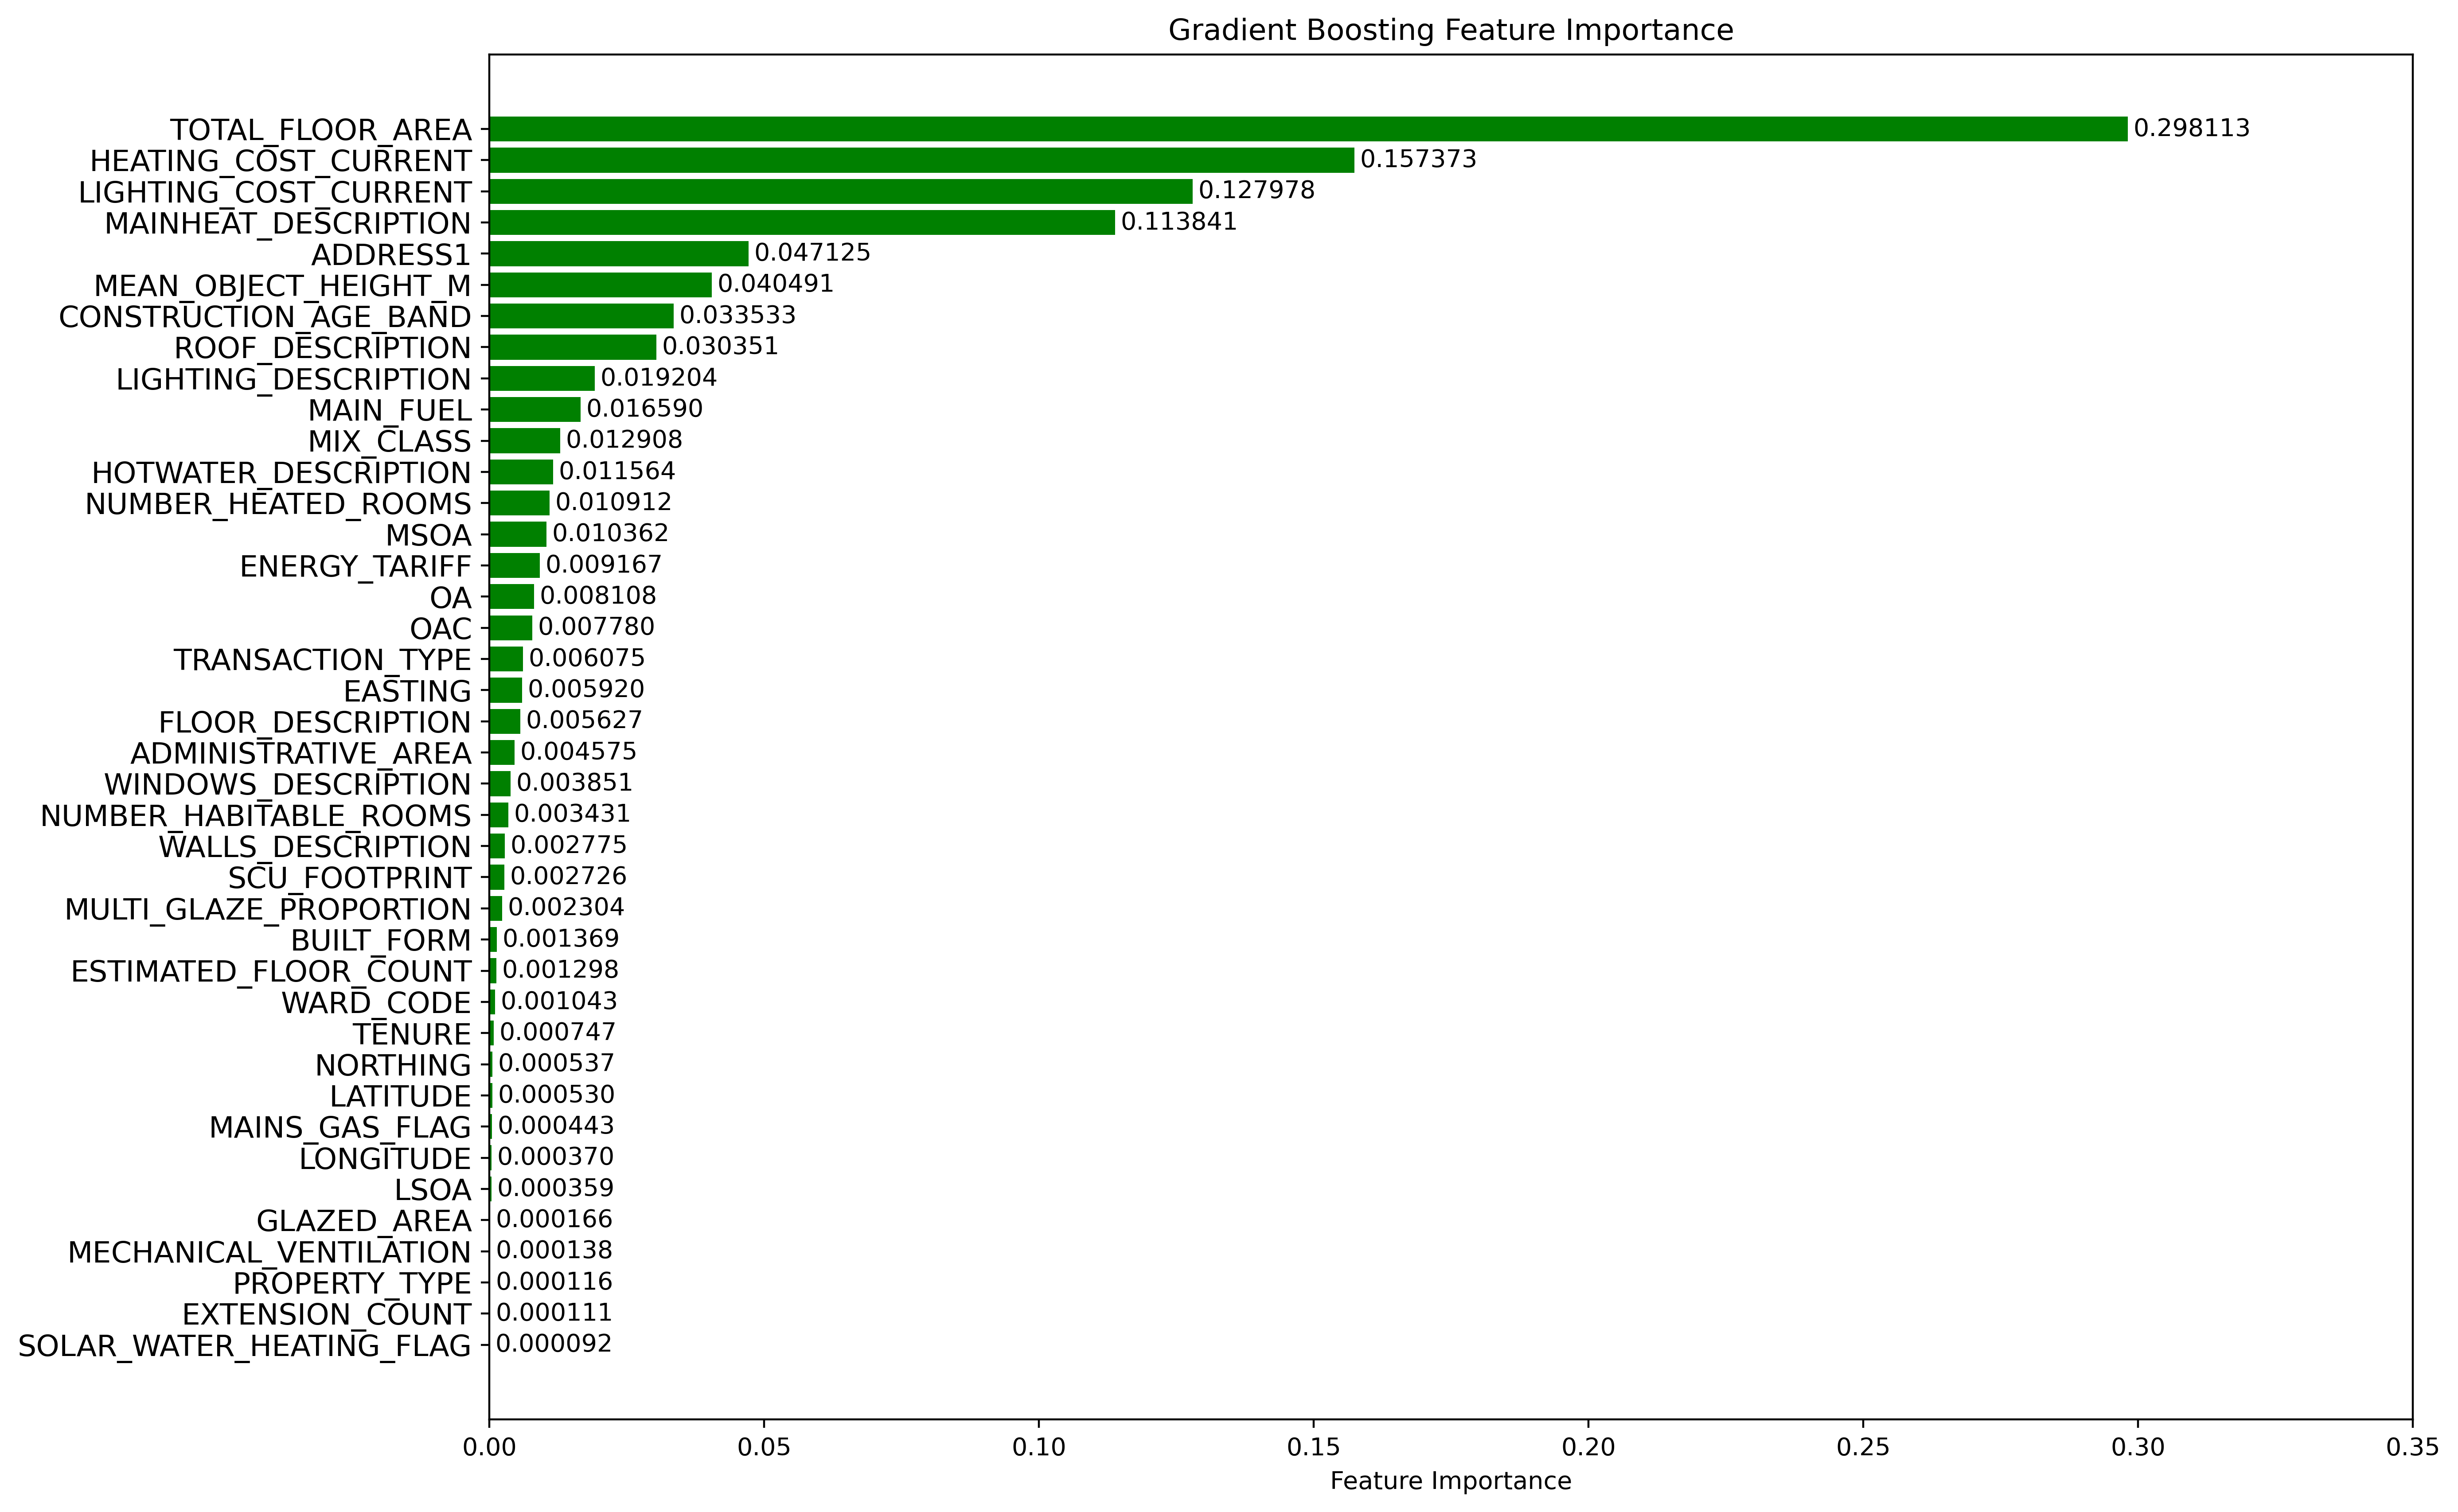

In [32]:
plot_features(gbr, X.columns,tittle='Gradient Boosting',xmax=0.35)

In [33]:
descending_gb =gbr_features.sort_values(by='Feature Importance', ascending=False).head(20)
descending_gb

,Feature Importance
TOTAL_FLOOR_AREA,0.298113
HEATING_COST_CURRENT,0.157373
LIGHTING_COST_CURRENT,0.127978
MAINHEAT_DESCRIPTION,0.113841
ADDRESS1,0.047125
MEAN_OBJECT_HEIGHT_M,0.040491
CONSTRUCTION_AGE_BAND,0.033533
ROOF_DESCRIPTION,0.030351
LIGHTING_DESCRIPTION,0.019204
MAIN_FUEL,0.016590


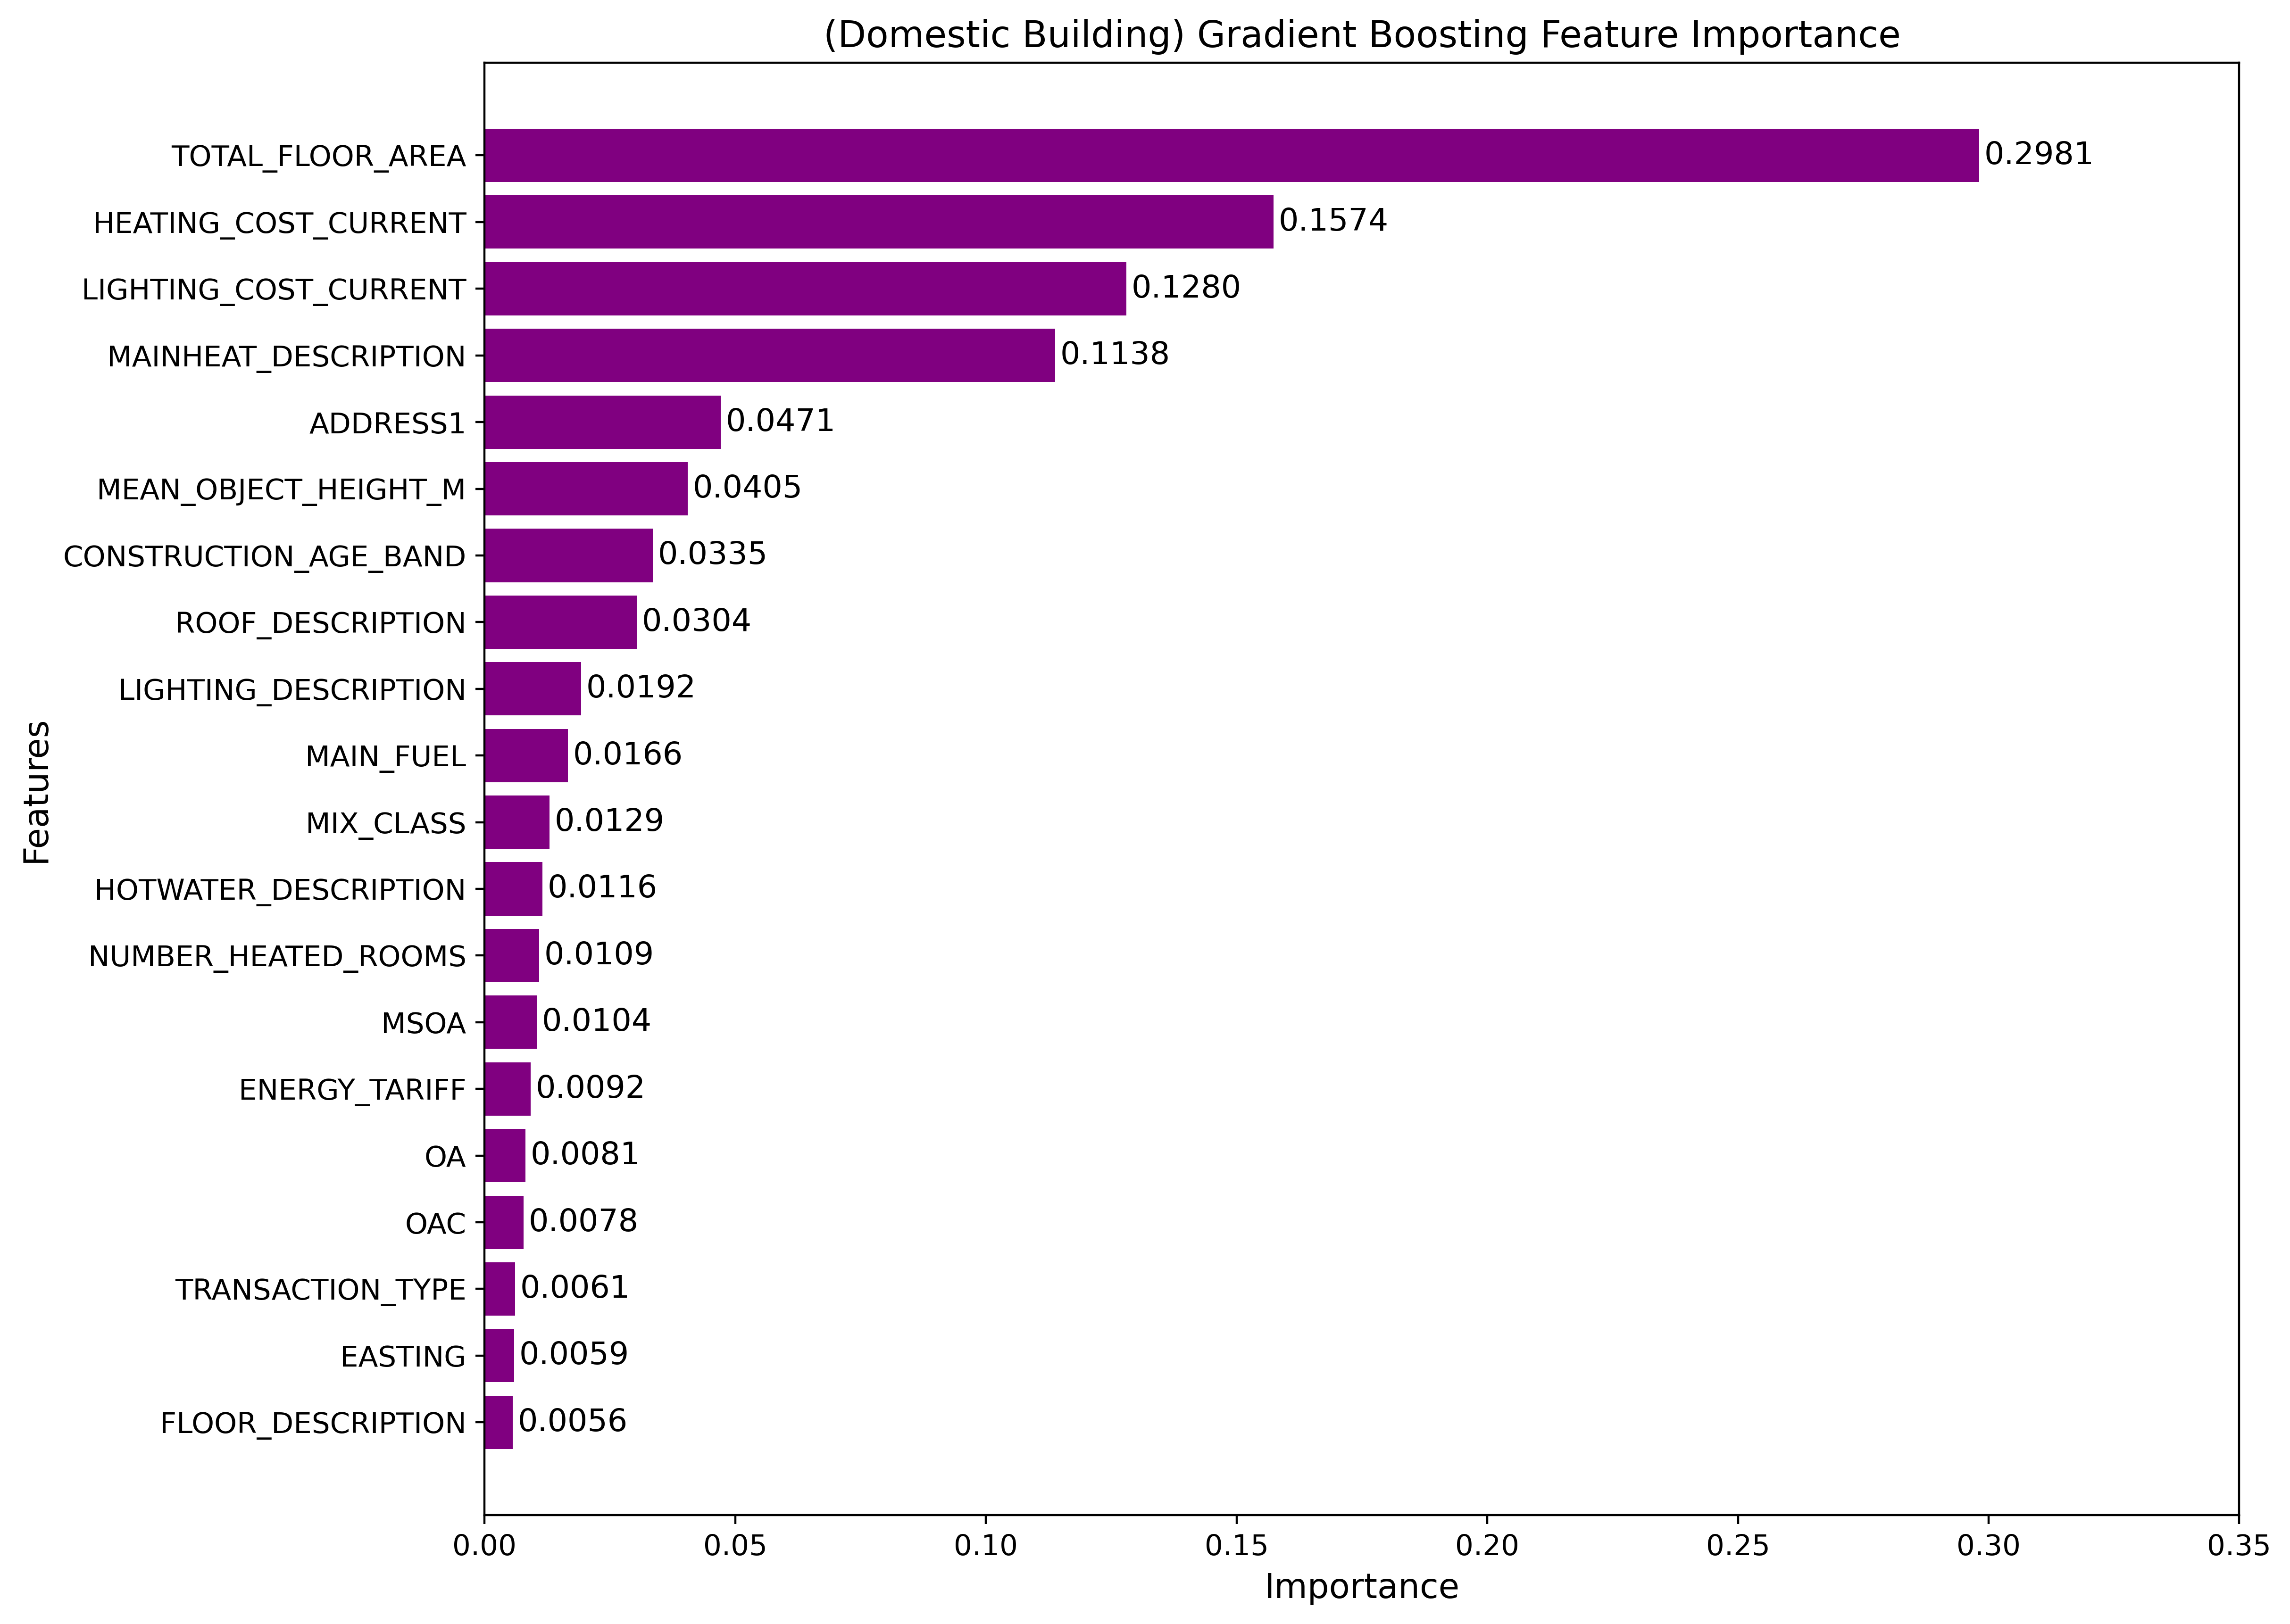

In [34]:
 plot_25(descending_gb, tittle='(Domestic Building) Gradient Boosting Feature Importance',xmax=0.35)

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;From the figure above, this model has been optimized based on some 
parameters selected from a paper that studied the correlation of energy consumption
with greenhouse gaseous (GHG) emissions. The features ranking for EPC and the feature importance
score are similar. However, since EPC has more spatial features,
some LBSM features are rearranged and reduced from four LBSM
features in the top 15 (based on the thesis report) to only three LBSM features in the top 15 domestic buildings from
the EPC and LBSM integration dataset. The LBSM features in the first fifteenth features
are Mean Object Height (Height of a building), Mix class and MSOA. The other features 
shown in the figure are OA (Output Area), OAC (Census Output Area Classification) and Easting.<div>

## 2.3 XGBOOST[^](#index) <a name="2.3"></a> 

In [ ]:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [110]:
from xgboost import XGBRegressor

xgb=XGBRegressor(
  #objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=1,
    #subsample=0.8,
    #colsample_bytree=0.8,
    n_estimators=200,
    #booster='gbtree',
    use_label_encoder=False,
    ) 
xgb_train, xgb_tt = time_taken(xgb, X_train,  Y_train)


Time taken to train the model: 0.47329092025756836 seconds


In [111]:
pred=xgb.predict(X_test)
xgb_result =model_eval(Y_test, pred,result=True)

print(xgb_result)

{'R-squared': 0.9070444361182253, 'MAE': 20.052698694722466, 'MSE': 1212.0553214663562, 'RMSE': 34.814584895792684}


In [125]:
param_XGB={
    
    'n_estimators':[10,50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
   
    
}


In [126]:
cross_val_score(xgb,X_train,  Y_train,cv=10)
cross_val_score(xgb,X_train,  Y_train,cv=2,n_jobs=-1).mean()
xgb_cv=GridSearchCV(estimator=xgb,param_grid=param_XGB,
                    cv=2,n_jobs=-1)
xgb_cv.fit(X_train,  Y_train)
pred1=xgb_cv.predict(X_test)
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}

In [112]:
xgbf=pd.DataFrame(xgb.feature_importances_,index=X.columns,columns=['Feature Importance'])


In [113]:
xgb.feature_importances_

array([0.0021963 , 0.09339668, 0.00331741, 0.00767676, 0.06849267,
       0.01348551, 0.00428817, 0.00345534, 0.00448173, 0.00212263,
       0.00043121, 0.00236088, 0.00126699, 0.01913896, 0.06275038,
       0.23006286, 0.05114039, 0.03330858, 0.07295921, 0.00725333,
       0.00214104, 0.02015265, 0.11641875, 0.01632987, 0.05858939,
       0.02933257, 0.00214799, 0.03720476, 0.0015688 , 0.0009765 ,
       0.00366233, 0.00154033, 0.00147918, 0.00132679, 0.00199097,
       0.00173431, 0.00180265, 0.00475148, 0.00369872, 0.00956484],
      dtype=float32)

## 2.4 RF[^](#index) <a name="2.4"></a> 

In [41]:
{'criterion': 'poisson',
 'max_features': 9,
 'min_samples_leaf': 3,
 'n_estimators': 500}

{'criterion': 'poisson',
 'max_features': 3,
 'min_samples_leaf': 3,
 'n_estimators': 250}

In [52]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(
    bootstrap= True,
    criterion= 'poisson',

 max_features= 9,

 min_samples_leaf= 3,
 n_estimators=500,
oob_score= True,
random_state=42,
verbose= 1,
 warm_start= False)
rf_train,rf_tt = time_taken(rfr,X_train,  Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.1s finished


Time taken to train the model: 28.794358491897583 seconds


In [53]:
rfr_pred=rfr.predict(X_test)
rfr_result =model_eval(Y_test,rfr_pred,result=True)

print(rfr_result)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'R-squared': 0.8066277876067536, 'MAE': 26.687491547270284, 'MSE': 2126.955921548025, 'RMSE': 46.11893235481525}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


In [52]:
param_RF={
    'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'n_estimators':[100,250,500],
    'max_features':[1,3,5,7,9],
    'min_samples_leaf':[3,5,15,25]
}

In [83]:
rfr1= GridSearchCV(rfr,param_RF,cv=2,n_jobs=1) #TO FIND THE BEST PARAMS
rfr1.fit(X_train,  Y_train)
pred_rfr=rfr1.predict(X_test)
rfr1.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   36.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   55.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Us

{'criterion': 'poisson',
 'max_features': 9,
 'min_samples_leaf': 3,
 'n_estimators': 500}

## 2.5 DT[^](#index) <a name="2.5"></a> 

In [ ]:
{'criterion': 'squared_error',
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'random_state': 52,
 'splitter': 'best'}

In [124]:
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor(criterion='squared_error',
                           splitter='best',
                            min_samples_split=25, 
                            min_samples_leaf=5,
                            max_features=7,  
                            random_state=52)


dtc_train, dtc_tt = time_taken(dt, X_train, Y_train)


Time taken to train the model: 0.06414270401000977 seconds


In [125]:
dt_pred=dt.predict(X_test)
dt_result =model_eval(Y_test,dt_pred,result=True)

print(dt_result)

{'R-squared': 0.6691892987768437, 'MAE': 42.12270968873603, 'MSE': 4313.468221498869, 'RMSE': 65.67699918159225}


In [45]:
cross_val_score(dt,X_train,  Y_train,cv=10)

array([0.58794926, 0.42842059, 0.64622442, 0.56439574, 0.50360306,
       0.60865555, 0.57915356, 0.59161551, 0.56851588, 0.58487808])

In [46]:
dtparam={
  'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'splitter':['best', 'random'],
    'max_features':[1,3,5,7,9],
    'min_samples_leaf':[3,5,15,25],
        'min_samples_split':[2,5,15,25],
            'random_state':[21,42,52]
}

In [79]:

cross_val_score(dt,X_train,  Y_train,cv=2,n_jobs=-1).mean()
dt_cv=GridSearchCV(estimator=dt,param_grid=dtparam,
                    cv=2,n_jobs=-1)
dt_cv.fit(X_train,  Y_train)
pred1=dt_cv.predict(X_test)
dt_cv.best_params_

{'criterion': 'squared_error',
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'random_state': 52,
 'splitter': 'best'}

In [126]:
dtf=pd.DataFrame(dt.feature_importances_,index=X.columns,columns=['Feature Importance'])


In [ ]:
 plot_25(descenddt , tittle='(Domestic Building) Decision Tree Feature Importance ',xmax=0.35)

# 3. Sorting Feature Importance for Public Building [^](#index) <a name="3"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;Random Forest appears to be the best model for public buildings 
to sort feature importance from the integration between DEC and LBSM datasets. 
The integration of these two datasets consists of 23586 rows with 74 columns composed of 
multiple features. After dropping the unnecessary features, there are 27 spatial features.
The DEC dataset has no socioeconomic features and more contribution of spatial features 
from the LBSM dataset.<div>

In [2]:
pb='/home/ffs223/Downloads/GHGs_coding/DOM_Main code/Job Portfolio/MRES_Project/2.2_PB_1723.csv'
df_pb=pd.read_csv(pb)
df_pb

,LMK_KEY,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_OPERATIONAL_RATING,YR1_OPERATIONAL_RATING,YR2_OPERATIONAL_RATING,OPERATIONAL_RATING_BAND,ELECTRIC_CO2,HEATING_CO2,RENEWABLES_CO2,...,DOMINANT_ND_ACTIVITY_BY_C2_COUNT,DEC_COUNT,EPC_RATING_COUNT_DOM,EPC_RATING_COUNT_NONDOM,AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT,AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT,COUNT_ND_UPRNS_bin,ESTIMATED_FLOOR_COUNT_bin,ESTIMATED_FLOOR_COUNT_binnumeric,COUNT_ND_binnumeric
0,18071,3730,4716,106.0,112.0,95.0,5,69.0,128.0,0.0,...,2,6,0,0,64.0,3,Greater than 150,41-50,9.0,6
1,18072,3730,4716,91.0,106.0,112.0,4,69.0,99.0,0.0,...,2,6,0,0,64.0,3,101-150,21-30,7.0,5
2,18070,3730,4716,95.0,95.0,95.0,4,86.0,97.0,0.0,...,2,6,0,0,64.0,3,Greater than 150,Greater than 50,10.0,6
3,18073,3730,4716,112.0,95.0,104.5,5,89.0,118.0,0.0,...,2,6,0,0,64.0,3,101-150,Greater than 50,10.0,5
4,7193,3730,69,88.0,91.0,106.0,4,61.0,99.0,0.0,...,2,6,0,0,64.0,3,101-150,Greater than 50,10.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,21689,442,3048,124.0,161.0,113.0,5,37.0,0.0,0.0,...,7,0,0,1,68.0,3,101-150,Greater than 50,10.0,5
23582,22497,981,3505,83.0,100.5,71.5,4,1521.0,462.0,0.0,...,2,0,0,0,69.0,2,Greater than 150,Greater than 50,10.0,6
23583,22994,970,3081,74.0,97.0,85.0,3,81.0,54.0,0.0,...,3,0,0,0,75.0,2,11-30,Greater than 50,10.0,2
23584,20851,970,3081,82.0,74.0,97.0,4,92.0,60.0,0.0,...,3,0,0,0,75.0,2,11-30,31-40,8.0,2


In [3]:
df_pb['TOTAL_Energy(kwh/m2)'] = df_pb['ANNUAL_ELECTRICAL_FUEL_USAGE'] + df_pb['ANNUAL_THERMAL_FUEL_USAGE']

In [4]:
cols = df_pb.columns.tolist()

# Rearrange energy column to the first column in the dom_df
cols.insert(0, cols.pop(cols.index('TOTAL_Energy(kwh/m2)')))


# Update new arrangement
df_pb = df_pb[cols]

In [6]:
df_pb.to_csv('3. PB_1723.csv',index=False)

In [7]:
drop1=['NOMINATED_DATE', 'LODGEMENT_DATETIME',
       'LODGEMENT_DATE','UPRN_SOURCE','OS_TOPO_TOID',
       'EPC_RATING_COUNT_NONDOM',
       'LMK_KEY', 'POSTCODE','BUILDING_REFERENCE_NUMBER','POSTTOWN',
       'OR_ASSESSMENT_END_DATE','LOCAL_AUTHORITY_LABEL',
       'CONSTITUENCY_LABEL', 'CURRENT_OPERATIONAL_RATING','OPERATIONAL_RATING_BAND',
      'year','AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT',
      'DEC_COUNT', 'MAIN_BENCHMARK',
       'TYPICAL_THERMAL_FUEL_USAGE',  'TYPICAL_ELECTRICAL_FUEL_USAGE',
       'RENEWABLES_FUEL_THERMAL','BUILDING_ENVIRONMENT',
       'RENEWABLES_ELECTRICAL', 'YR1_ELECTRICITY_CO2', 'YR2_ELECTRICITY_CO2',
       'YR1_HEATING_CO2', 'YR2_HEATING_CO2', 'YR1_RENEWABLES_CO2','ESTIMATED_FLOOR_COUNT',
       'YR2_RENEWABLES_CO2', 'NOMINATED_DATE','SCU_ID','WARD','ESTIMATED_FLOOR_COUNT_binnumeric',
       'EPC_RATING_COUNT_DOM','COUNT_ND_UPRNS_bin','ESTIMATED_FLOOR_COUNT_bin',
       'YR1_OPERATIONAL_RATING', 'YR2_OPERATIONAL_RATING', 'COUNT_ND_binnumeric','COUNT_ND_UPRNS',
       'ANNUAL_ELECTRICAL_FUEL_USAGE', 'ANNUAL_THERMAL_FUEL_USAGE','ESTIMATE_TOTAL_FLOOR_AREA_ALL',
       'AC_INSPECTION_COMMISSIONED','DOMINANT_ND_ACTIVITY_BY_C2_COUNT','AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT'
      ]

df_pb .drop(columns=drop1,axis=1,inplace=True)
#total energy from annual thermal & electrical
#avg from typcal electrical & thermal

/tmp/ipykernel_60909/3715049055.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pb .drop(columns=drop1,axis=1,inplace=True)


In [8]:
df_pb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23586 entries, 0 to 23585
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TOTAL_Energy(kwh/m2)  23586 non-null  float64
 1   ELECTRIC_CO2          23586 non-null  float64
 2   HEATING_CO2           23586 non-null  float64
 3   RENEWABLES_CO2        23586 non-null  float64
 4   PROPERTY_TYPE         23586 non-null  int64  
 5   INSPECTION_DATE       23586 non-null  object 
 6   LOCAL_AUTHORITY       23586 non-null  int64  
 7   CONSTITUENCY          23586 non-null  int64  
 8   MAIN_HEATING_FUEL     23586 non-null  int64  
 9   TOTAL_FLOOR_AREA      23586 non-null  int64  
 10  AIRCON_PRESENT        23586 non-null  int64  
 11  BUILDING_CATEGORY     23586 non-null  int64  
 12  ADDRESS               23586 non-null  int64  
 13  OCCUPANCY_LEVEL       23586 non-null  int64  
 14  UPRN                  23586 non-null  float64
 15  EASTING            

In [9]:
df_pb.set_index(['UPRN','INSPECTION_DATE','ELECTRIC_CO2', 'HEATING_CO2', 'RENEWABLES_CO2'], inplace=True)

In [10]:
df_pb.isnull().sum()

TOTAL_Energy(kwh/m2)    0
PROPERTY_TYPE           0
LOCAL_AUTHORITY         0
CONSTITUENCY            0
MAIN_HEATING_FUEL       0
TOTAL_FLOOR_AREA        0
AIRCON_PRESENT          0
BUILDING_CATEGORY       0
ADDRESS                 0
OCCUPANCY_LEVEL         0
EASTING                 0
NORTHING                0
LATITUDE                0
LONGITUDE               0
OA                      0
LSOA                    0
MSOA                    0
OAC                     0
WARD_CODE               0
ADMINISTRATIVE_AREA     0
SCU_FOOTPRINT           0
MEAN_OBJECT_HEIGHT_M    0
MIX_CLASS               0
dtype: int64

In [11]:
x = df_pb.drop(columns=['TOTAL_Energy(kwh/m2)'])
y = df_pb['TOTAL_Energy(kwh/m2)']


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2,random_state=21)

In [13]:
X_train.shape

(18868, 22)

In [14]:
x.columns

Index(['PROPERTY_TYPE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'MAIN_HEATING_FUEL',
       'TOTAL_FLOOR_AREA', 'AIRCON_PRESENT', 'BUILDING_CATEGORY', 'ADDRESS',
       'OCCUPANCY_LEVEL', 'EASTING', 'NORTHING', 'LATITUDE', 'LONGITUDE', 'OA',
       'LSOA', 'MSOA', 'OAC', 'WARD_CODE', 'ADMINISTRATIVE_AREA',
       'SCU_FOOTPRINT', 'MEAN_OBJECT_HEIGHT_M', 'MIX_CLASS'],
      dtype='object')

## 3.1 GBOOST[^](#index) <a name="3.1"></a> 

In [76]:
gbr_pb=GradientBoostingRegressor(learning_rate= 0.2,
 max_depth= 5,
 min_samples_leaf= 1,
 min_samples_split=3,
 n_estimators= 500)



gbr_t, gbr_tt = time_taken(gbr_pb, X_train, Y_train)

Time taken to train the model: 34.507710218429565 seconds


In [77]:
ypred_gb=gbr_pb.predict(X_test)
gb_pb =model_eval(Y_test, ypred_gb,result=True)
print(gb_pb)

{'R-squared': 0.6486469814229228, 'MAE': 40.45344168371437, 'MSE': 7426.232407270242, 'RMSE': 86.17559055364949}


In [ ]:
param_gridgb={
    
    'n_estimators':[50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3],
 
}

In [ ]:
cross_val_score(gbr_pb,X_train,  Y_train,cv=3,n_jobs=-1).mean()
gbr_cv=GridSearchCV(estimator=gbr_pb,param_grid=param_gridgb,
                    cv=3,n_jobs=-1,scoring='r2')
gbr_cv.fit(X_train,  Y_train)
Ypred=gbr_cv.predict(X_train)
gbr_cv.best_params_

## 3.2 XGBOOST[^](#index) <a name="3.2"></a> 

In [83]:

xgb_pb=XGBRegressor(
  #objective='reg:squarederror',
    learning_rate=0.2,
    max_depth=3,
    #min_child_weight=1,
    #subsample=0.8,
    #colsample_bytree=0.8,
    n_estimators=500,
    #booster='gbtree',
    #use_label_encoder=False,
    ) 
xgb_train, xgb_tt = time_taken(xgb_pb, X_train, Y_train)

Time taken to train the model: 0.48686933517456055 seconds


In [84]:
xgb_pred=xgb_pb.predict(X_test)
xpb_result =model_eval(Y_test, xgb_pred,result=True)

print(xpb_result)

{'R-squared': 0.5906302314201344, 'MAE': 49.7914356281819, 'MSE': 8652.480215756588, 'RMSE': 93.01870895554607}


In [ ]:
param_XGB={
    
    'n_estimators':[10,50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
   
    
}


In [ ]:
cross_val_score(xgb_pb,X_train, Y_train,cv=2,n_jobs=-1).mean()
xgb_cv=GridSearchCV(estimator=xgb_pb,param_grid=param_XGB,
                    cv=2,n_jobs=-1)
xgb_cv.fit(X_train, Y_train)
pred1=xgb_cv.predict(X_test)
xgb_cv.best_params_

## 3.3 RF[^](#index) <a name="3.3"></a> 

In [ ]:
{'criterion': 'absolute_error',
 'max_features': 5,
 'min_samples_split': 3,
 'n_estimators': 500}

In [22]:
rf_pb=RandomForestRegressor(
    bootstrap= True,
    criterion= 'poisson',

 max_features=9,

 min_samples_split= 3,
 n_estimators=500,
oob_score= True,
random_state=42,
verbose= 1,
 warm_start= False)
rf_train,rf_tt = time_taken(rf_pb, X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   39.9s finished


Time taken to train the model: 40.92861747741699 seconds


In [23]:
rf_pred=rf_pb.predict(X_test)
rf_result =model_eval(Y_test,rf_pred,result=True)

print(rf_result)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'R-squared': 0.690911268666841, 'MAE': 37.071665999327585, 'MSE': 6532.930221132598, 'RMSE': 80.82654403803615}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


In [87]:
param_rfr={
    'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'n_estimators':[100,250,500],
    'max_features':[1,3,5,7,9],
    'min_samples_split':[3,5,7,12]
}

In [88]:
rfr1= GridSearchCV(rf_pb,param_rfr,cv=2,n_jobs=1) #TO FIND THE BEST PARAMS
rfr1.fit(X_train,  Y_train)
pred_rfr=rfr1.predict(X_test)
rfr1.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 17.5min finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'criterion': 'absolute_error',
 'max_features': 5,
 'min_samples_split': 3,
 'n_estimators': 500}

In [24]:
features_rf=pd.DataFrame(rf_pb.feature_importances_,index=x.columns,columns=['Feature Importance'])
features_rf

,Feature Importance
PROPERTY_TYPE,0.202353
LOCAL_AUTHORITY,0.008786
CONSTITUENCY,0.018399
MAIN_HEATING_FUEL,0.021695
TOTAL_FLOOR_AREA,0.062855
AIRCON_PRESENT,0.028786
BUILDING_CATEGORY,0.141651
ADDRESS,0.044404
OCCUPANCY_LEVEL,0.035467
EASTING,0.029230


In [25]:
rf_pb.feature_importances_

array([0.20235345, 0.00878611, 0.0183992 , 0.02169513, 0.06285478,
       0.02878626, 0.14165109, 0.04440423, 0.03546681, 0.02922991,
       0.02626875, 0.02679676, 0.0304031 , 0.02757106, 0.02374405,
       0.02401185, 0.02653663, 0.02569612, 0.01235032, 0.12775301,
       0.04382721, 0.01141417])

In [26]:
descend_rf = features_rf.sort_values(by='Feature Importance', ascending=False).head(20)
descend_rf

,Feature Importance
PROPERTY_TYPE,0.202353
BUILDING_CATEGORY,0.141651
SCU_FOOTPRINT,0.127753
TOTAL_FLOOR_AREA,0.062855
ADDRESS,0.044404
MEAN_OBJECT_HEIGHT_M,0.043827
OCCUPANCY_LEVEL,0.035467
LONGITUDE,0.030403
EASTING,0.029230
AIRCON_PRESENT,0.028786


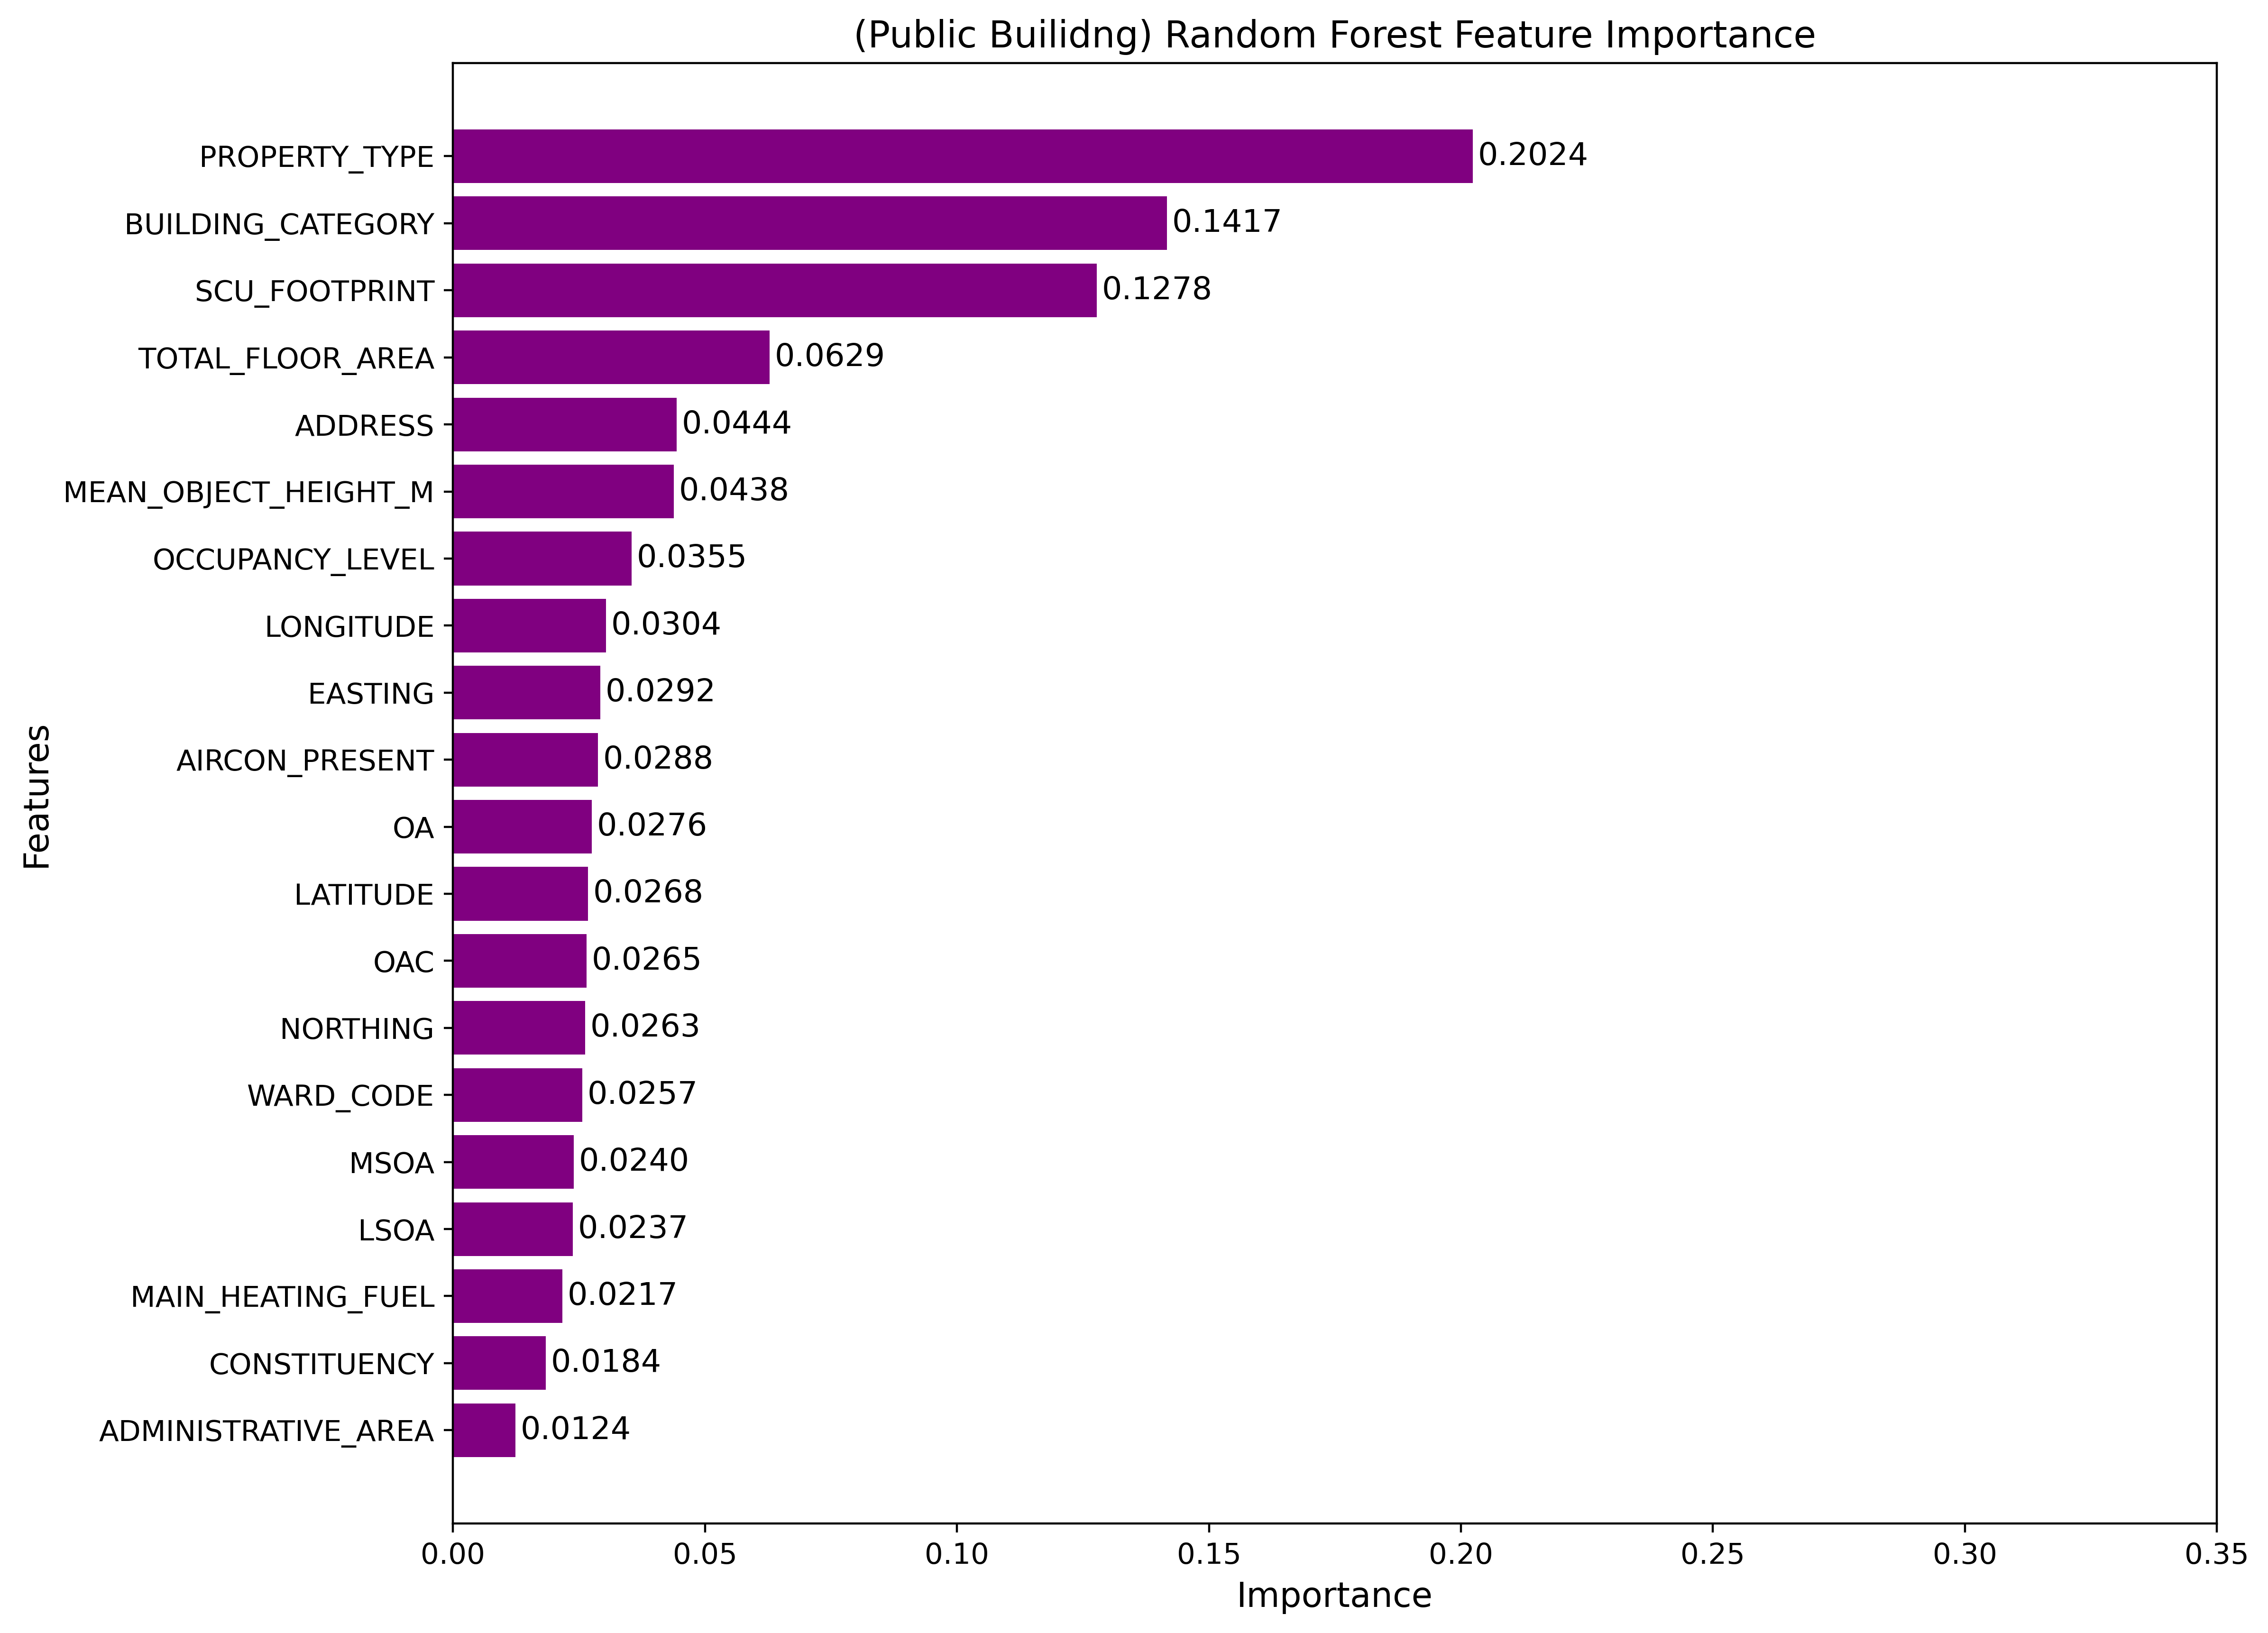

In [27]:
 plot_25(descend_rf, tittle='(Public Builidng) Random Forest Feature Importance',xmax=0.35)

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;The figure above shows the features of integrating the DEC and LBSM 
datasets sorted in rank. The highest LBSM feature is at the third rank, which is the SCU footprint,
followed by Mean Object Height, Longitude, Easting, OA, Latitude, OAC, Northing, Ward Code, MSOA,
and Administrative Area. Similar to domestic buildings, only the top 15 features are selected
as input for further analysis since the importance score from the sixteenth feature onward is
depreciated.<div>

## 3.4 DT[^](#index) <a name="3.4"></a> 

In [22]:


dt_pb = DecisionTreeRegressor(criterion='squared_error',
                           splitter='best',
                            min_samples_split=25, 
                            min_samples_leaf=5,
                            max_features=7,  
                            random_state=52)


dtc_train, dtc_tt = time_taken(dt_pb, X_train, Y_train)

Time taken to train the model: 0.07393598556518555 seconds


In [23]:
dt_pred=dt_pb.predict(X_test)
dt_result =model_eval(Y_test,dt_pred,result=True)

print(dt_result)

{'R-squared': 0.6675942489652316, 'MAE': 42.294108020916376, 'MSE': 4334.266208530902, 'RMSE': 65.83514417490784}


# 4. Conclusion [^](#index) <a name="4"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;From both figures of Gradient Boosting for domestic buildings and 
Random forest for public buildings, features importance of have more contribution from EPC
while for public buildings the contribution is more from LBSM features instead of from DEC.
This is because EPC has more spatial and socioeconomic features compared to DEC. Further analysis
has been done in the notebook to study the impact of these features to the estimated energy consumption
between domestic and public buildings.<div>

# 5. References [^](#index) <a name="5"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">

[1] Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In
Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge
Discovery and Data Mining (pp. 785-794).

[2] R. Jiang, W. Tang, X. Wu, W. Fu, A random forest approach to the detection of
epistatic interactions in case-control studies, BMC Bioinform. 10 (1) (2009) 1.


[3] AlShafeey, M., & Rashdan, O. (2023). Quantifying the impact of energy consumption
sources on GHG emissions in major economies: A machine learning approach. Energy
Strategy Reviews, 49, 101159. https://doi.org/10.1016/j.esr.2023.101159